In [1]:
import numpy as np
import os
import math

from PIL import Image

# Clustering
from sklearn.cluster import AgglomerativeClustering # 1) Agglomerative-Hierarchical
from sklearn.cluster import KMeans                  # 2) K-Means
from sklearn.mixture import GaussianMixture         # 3) Gaussian Mixture Models

from sklearn.preprocessing import StandardScaler
# Evaluation
from sklearn import metrics
from skimage.external import tifffile
from skimage.measure import compare_mse
from skimage.metrics import structural_similarity as ssim

from sklearn.decomposition import PCA, KernelPCA               # 2) PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt 
%matplotlib inline
import newscripts as myutils

Using TensorFlow backend.


In [9]:
# Data loading

# directory = "../../Data/train"
directory = "../../Data/Kather_all"
namesandvalues = myutils.loadData(directory)
meanMatrix = np.asarray(namesandvalues[0])
image_names = namesandvalues[1]

labels_true = myutils.loadLabelsFromsubdirectoryindex(image_names, "../../Data/Kather_original")

In [3]:
# Data preprocessing

# Reshape for scaling and clustering (1 feature dimension)
meanMatrix = meanMatrix.reshape(meanMatrix.shape[0], -1) 
print(meanMatrix.shape)

# Scale
scaledMatrix = StandardScaler().fit_transform(meanMatrix)

(5000, 67500)


In [7]:
# PCA 
pca = PCA(n_components=0.99)
transformedData = pca.fit_transform(scaledMatrix)
pca.n_components_

1950

In [12]:
# PCA 
pca = PCA(n_components=0.95)
transformedData = pca.fit_transform(scaledMatrix)
pca.n_components_

553

In [9]:
# PCA 
pca = PCA(n_components=0.90)
transformedData = pca.fit_transform(scaledMatrix)
pca.n_components_

214

In [10]:
# PCA 
pca = PCA(n_components=0.85)
transformedData = pca.fit_transform(scaledMatrix)
pca.n_components_

91

In [11]:
# PCA 
pca = PCA(n_components=0.80)
transformedData = pca.fit_transform(scaledMatrix)
pca.n_components_

36

In [5]:
# PCA 
pca = PCA(n_components=2)
transformedData = pca.fit_transform(scaledMatrix)
# pca.n_components_


AttributeError: 'PCA' object has no attribute 'explained_variance_ratio'

In [6]:
pca.explained_variance_ratio_

array([0.6692294 , 0.02173688])

In [13]:
def ClusterAndPlot(n_clusters, D):
    Labels = []
    
    print(D.shape)
    # HC = AgglomerativeClustering(n_clusters=n_clusters, affinity='manhattan', linkage='complete').fit(D)
    # print('HC Silhouette Score  {} '.format(metrics.silhouette_score(D, HC.labels_)))

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(D)
    print('kmeans Silhouette Score  {} '.format(metrics.silhouette_score(D, kmeans.labels_)))

    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(D)
    # gmm = GaussianMixture(n_components=n_clusters, covariance_type='tied').fit(D)
    gmmlabels_ = gmm.predict(D)
    print('gmm Silhouette Score  {} '.format(metrics.silhouette_score(D, gmmlabels_)))
    
    fig, axs = plt.subplots(2, 2, figsize=(13, 7))
    axs[0, 0].scatter(D[:, 0], D[:, 1], cmap='viridis')
    axs[0, 0].set_title('Normal')
    axs[0, 1].axis('off')
    
    axs[0, 1].scatter(D[:, 0], D[:, 1], c=gmmlabels_, cmap='viridis')
    axs[0, 1].set_title('GMM')
    axs[0, 1].axis('off')
    
    axs[1, 0].scatter(D[:, 0], D[:, 1], c=kmeans.labels_, cmap='viridis')
    axs[1, 0].set_title('K-Means')
    axs[1, 0].axis('off')
    
    # axs[1, 1].scatter(D[:, 0], D[:, 1], c=HC.labels_, cmap='viridis')
    # axs[1, 1].set_title('HC')
    plt.show()
    
    # Labels.append(HC.labels_)
    Labels.append(kmeans.labels_)
    Labels.append(gmmlabels_)
    return Labels

(5000, 553)
kmeans Silhouette Score  0.1969314959294873 
gmm Silhouette Score  0.1881971386602751 


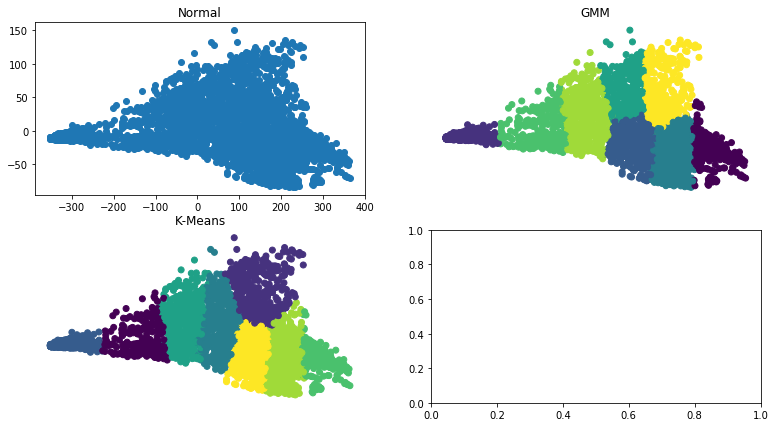

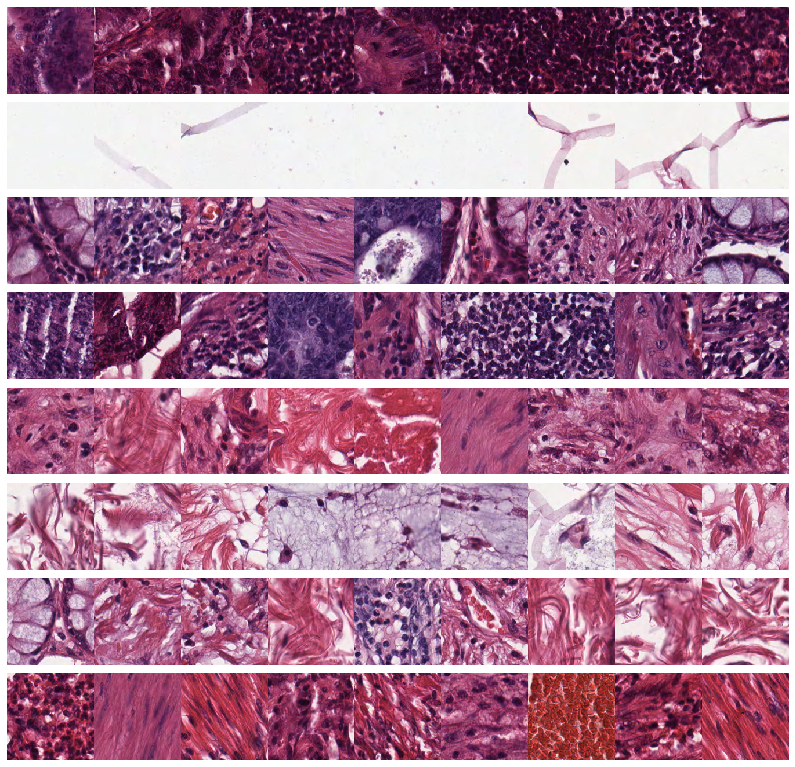

In [14]:
Labels = ClusterAndPlot(8, transformedData)
myutils.clusterintoDirectories(Labels[1], directory, image_names)
myutils.pltPathologyClusters(Labels[1], directory)

In [24]:
def evaluateAll3withLabels(Labels, labels_true):

    summ = 0
    algo_list = []
#     print(len(Labels))
    for i in range(len(Labels)): # 0 is k-means, 1 is gmms
        print("{}".format(i))
        print("Adjusted Rand index {}".format(metrics.adjusted_mutual_info_score(labels_true, Labels[i])))
        print("homogeneity_score {}".format(metrics.homogeneity_score(labels_true, Labels[i])))
        print("adjusted_rand_score {}".format(metrics.adjusted_rand_score(Labels[i],labels_true)))
        print("completeness_score {}".format(metrics.completeness_score(labels_true, Labels[i])))
        print("v_measure_score {}".format(metrics.v_measure_score(labels_true, Labels[i], beta=0.6)))
        print("")
        
        

In [25]:
evaluateAll3withLabels(Labels, labels_true)

0
Adjusted Rand index 0.47838880280227203
homogeneity_score 0.46812997301908393
adjusted_rand_score 0.33974916046021497
completeness_score 0.49175647184489535
v_measure_score 0.47671898080424696

1
Adjusted Rand index 0.49573179352571206
homogeneity_score 0.4855581786437427
adjusted_rand_score 0.3575046092634539
completeness_score 0.5088932339050987
v_measure_score 0.49405365113422717



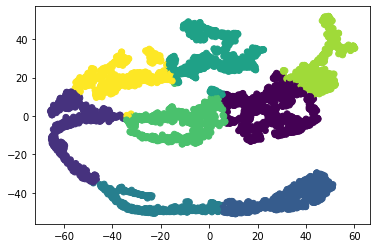

In [11]:
tsne1 = TSNE(n_components=2, perplexity = 50).fit_transform(transformedData)
kmeans1 = KMeans(n_clusters=8).fit(tsne1)

plt.scatter(tsne1[:, 0], tsne1[:, 1], c=kmeans1.labels_, cmap='viridis')